# Tutorial

ref: https://sep.readthedocs.io/en/v1.0.x/tutorial.html


This tutorial shows the basic steps of using SEP to detect objects in an image and perform some basic aperture photometry.


# Step 1: Install Astropy

In [1]:
!pip install astropy

# Step 2: Install SEP

In [2]:
!pip install sep

In [3]:
# Import necessary libraries
import numpy as np
import sep
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams


%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]
filename = "data/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits"
# download from: https://archive.stsci.edu/pub/hlsp/hudf12/
save_fig_path = 'figs/f105w/'


import os

if not os.path.exists(save_fig_path):
    os.makedirs(save_fig_path)

First, we’ll read an example image from a FITS file and display it, just to show what we’re dealing with. The example image is just 256 x 256 pixels.

In [4]:
# Load the image using astropy.io.fits
with fits.open(filename) as hdul:
    data = hdul[0].data.astype(np.float64)

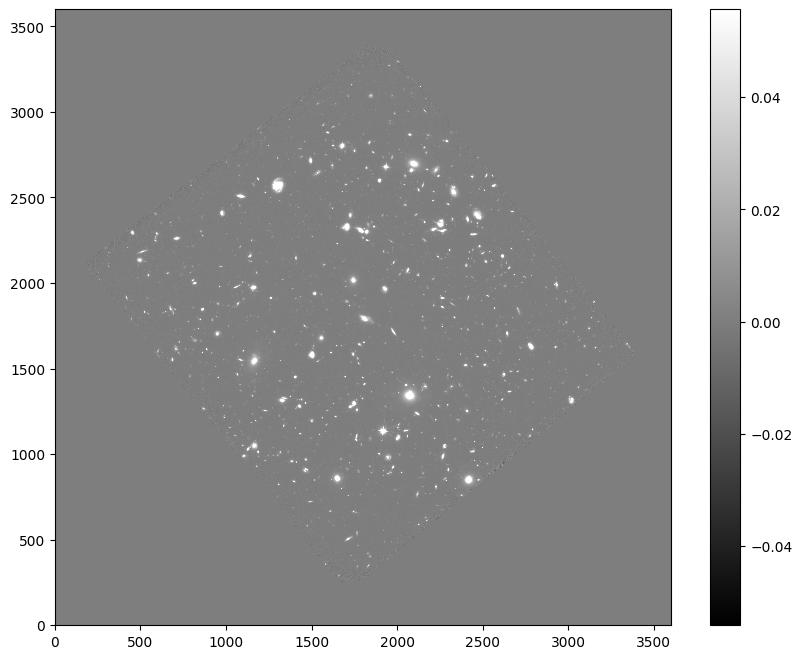

In [5]:
# Show the image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()
plt.savefig(save_fig_path + '1_image.png', dpi=300, bbox_inches='tight')

# Background subtraction

Measure a spatially varying background on the image

In [6]:
bkg = sep.Background(data)

There are various options for controlling the box size used in estimating the background.
It is also possible to mask pixels. For example:

In [7]:
# bkg = sep.Background(data, mask=mask, bw=64, bh=64, fw=3, fh=3)

Get a "global" mean and noise of the image background

In [8]:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


In [9]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

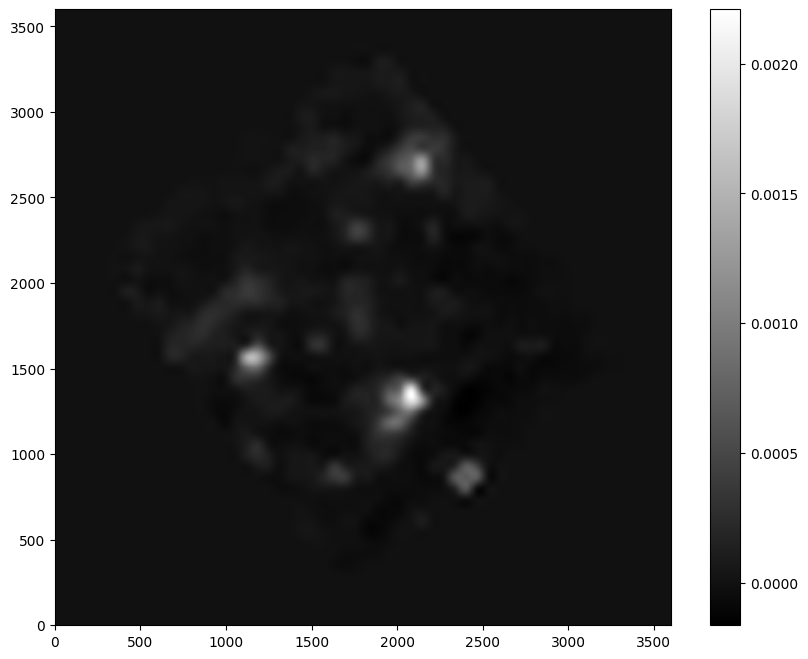

In [10]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.savefig(save_fig_path + '2_background.png', dpi=300, bbox_inches='tight')

In [11]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

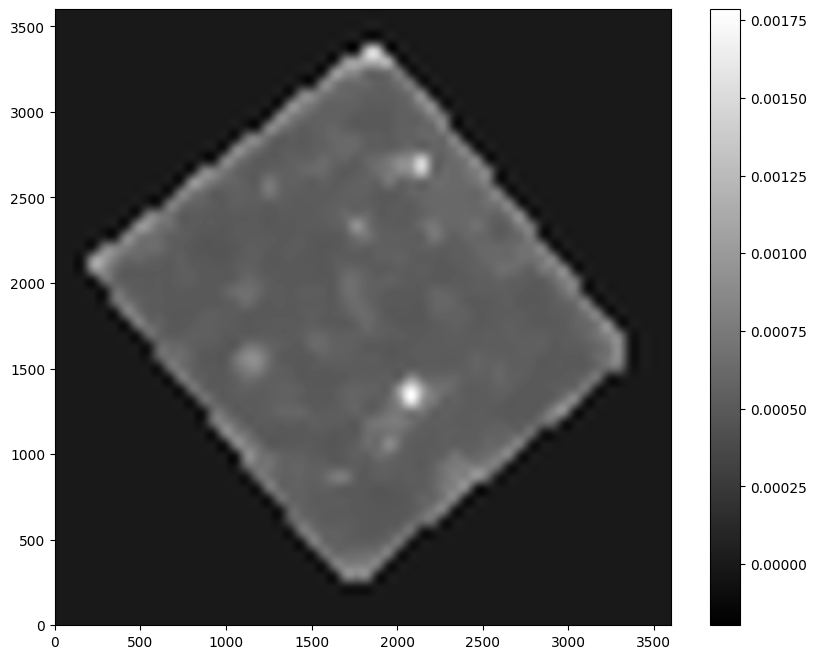

In [12]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.savefig(save_fig_path + '3_background_noise.png', dpi=300, bbox_inches='tight')

In [13]:
# Subtract the background
data_sub = data - bkg

# or
# bkg.subfrom(data)

# Object detection
Now that we’ve subtracted the background, we can run object detection on the background-subtracted data. You can see the background noise level is pretty flat. So here we’re setting the detection threshold to be a constant value of 1.5σ
 where σ
 is the global background RMS.

In [14]:
# Object detection with a threshold of 1.5
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

In [15]:
# How many objects were detected
print(f"Detected {len(objects)} objects")

Detected 8640 objects


objects['x'] and objects['y'] will give the centroid coordinates of the objects. Just to check where the detected objects are, we’ll over-plot the object coordinates with some basic shape parameters on the image:

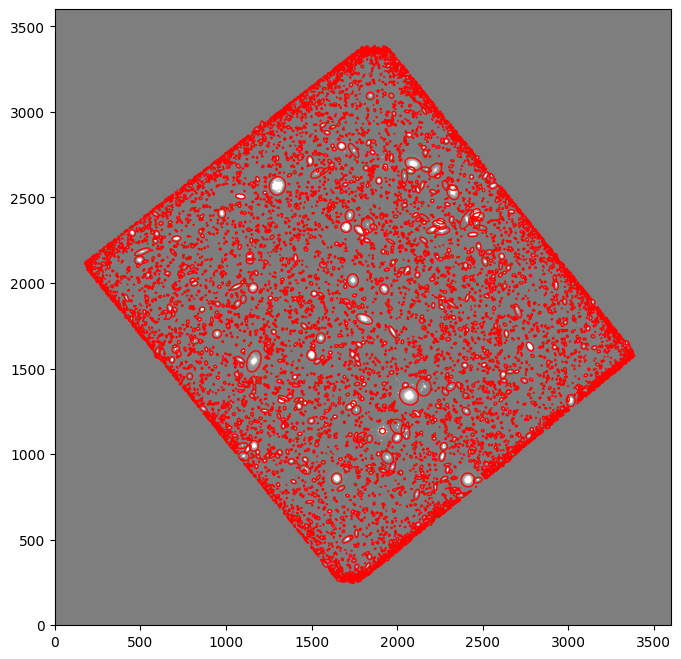

In [16]:
from matplotlib.patches import Ellipse


# Plot background-subtracted image with detected objects
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

# Plot an ellipse for each object
for obj in objects:
    e = Ellipse(xy=(obj['x'], obj['y']), width=6*obj['a'], height=6*obj['b'], angle=obj['theta'] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

plt.savefig(save_fig_path + '4_detected_objects.png', dpi=300, bbox_inches='tight')

objects has many other fields, giving information such as second moments, and peak pixel positions and values. See the reference documentation for sep.extract for descriptions of these fields. You can see the available fields:

In [17]:
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

# Aperture photometry

Finally, we’ll perform simple circular aperture photometry with a 3 pixel radius at the locations of the objects:

In [18]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=bkg.globalrms, gain=1.0)

flux, fluxerr and flag are all 1-d arrays with one entry per object.

In [19]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))


object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


# Histogram their fluxes.

[ 0.03128197  0.03101789 -0.02438809 ...  0.08851303  0.01802793
  0.01398957]
8640
8553


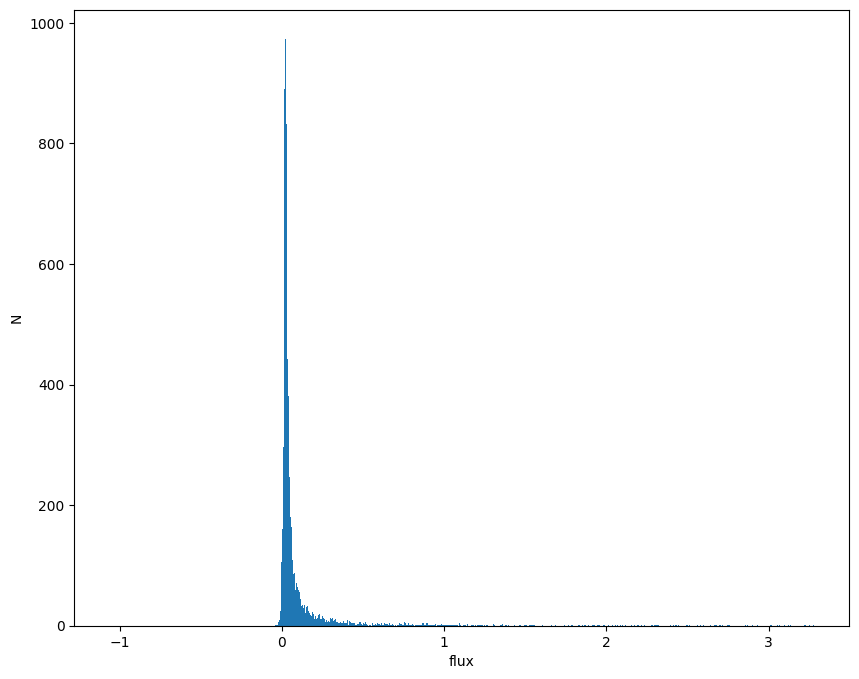

<Figure size 1000x800 with 0 Axes>

In [36]:
print(flux)
print(len(flux))

# Considering the largest outlier, we only want to plot the fluxes 
# that are less than the 99th percentile of the fluxes.
flux_threshold = np.percentile(flux, 99)
flux_clipped = flux[flux < flux_threshold]
print(len(flux_clipped))

plt.clf()
plt.hist(flux_clipped, bins='auto')
plt.xlabel('flux')
plt.ylabel('N')
plt.show()
plt.savefig(save_fig_path + '5_flux_histogram.png', dpi=300, bbox_inches='tight')

# Q7
What are the mean, median, and standard deviation of the distribution of fluxes. What is the largest outlier in the distribution, where is it on the image, and how many standard deviations is it away from the mean? 

In [21]:
mean_flux = np.mean(flux)
median_flux = np.median(flux)
std_dev_flux = np.std(flux)

print(f"Mean flux: {mean_flux}")
print(f"Median flux: {median_flux}")
print(f"Standard deviation of flux: {std_dev_flux}")

Mean flux: 0.36186200071901703
Median flux: 0.030956558069156016
Standard deviation of flux: 9.243527842776762


In [22]:
# Find the largest outlier
max_outlier = np.max(flux)
max_outlier_index = np.argmax(flux)
print(f"Largest outlier: {max_outlier}")
print(f"Index of largest outlier: {max_outlier_index}")

# Find the coordinates of the largest outlier
x_max_outlier = objects['x'][max_outlier_index]
y_max_outlier = objects['y'][max_outlier_index]

print(f"Coordinates of largest outlier: ({x_max_outlier}, {y_max_outlier})")

Largest outlier: 807.2972835731507
Index of largest outlier: 2066
Coordinates of largest outlier: (1914.2549094883857, 1134.3164850742164)


In [23]:
# Find the number of standard deviations the largest outlier is away from the mean
num_std_devs = (max_outlier - mean_flux) / std_dev_flux
print(f"Number of standard deviations the largest outlier is away from the mean: {num_std_devs}")

Number of standard deviations the largest outlier is away from the mean: 87.29734310293674


# Q8
8) Download the f125w and f160w images of the HUDF at the same website, and make a 3-color false image of the UDF using RGB -> f160w, f125w, f105w. Save the image as a PNG.

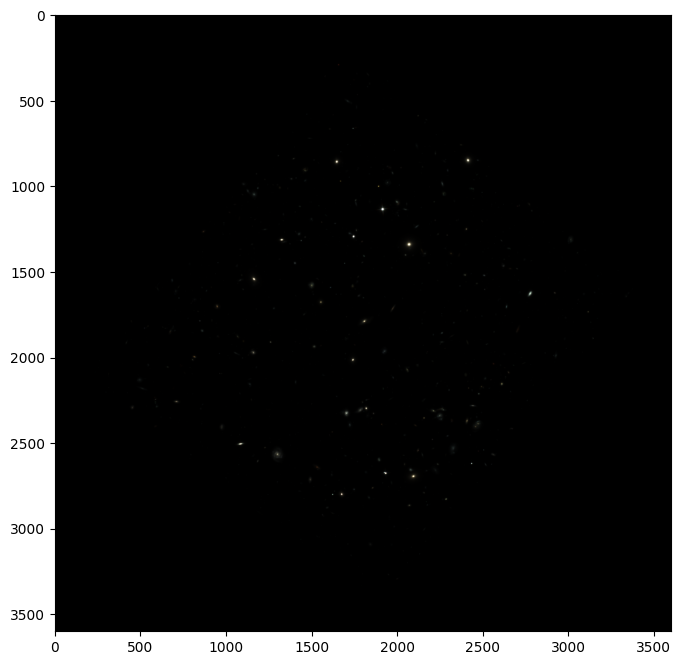

In [30]:
from astropy.io import fits
import matplotlib.pyplot as plt


f105w_file = "data/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits"
f125w_file = "data/hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits"
f160w_file = "data/hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits"


with fits.open(f160w_file) as hdul:
    f160w_data = hdul[0].data
with fits.open(f125w_file) as hdul:
    f125w_data = hdul[0].data
with fits.open(f105w_file) as hdul:
    f105w_data = hdul[0].data

rgb_image = np.stack([f160w_data, f125w_data, f105w_data], axis=-1)  # RGB
rgb_image = np.clip(rgb_image, 0, 1)

plt.imshow(rgb_image)
plt.imsave('figs/udf_rgb_image.png', rgb_image)